In [308]:
# Importing libs
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [309]:
df = pd.read_csv("winequality-white.csv", sep=";")

df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

In [310]:
x = df[df.columns[:-1]].values
y = df["quality"].values

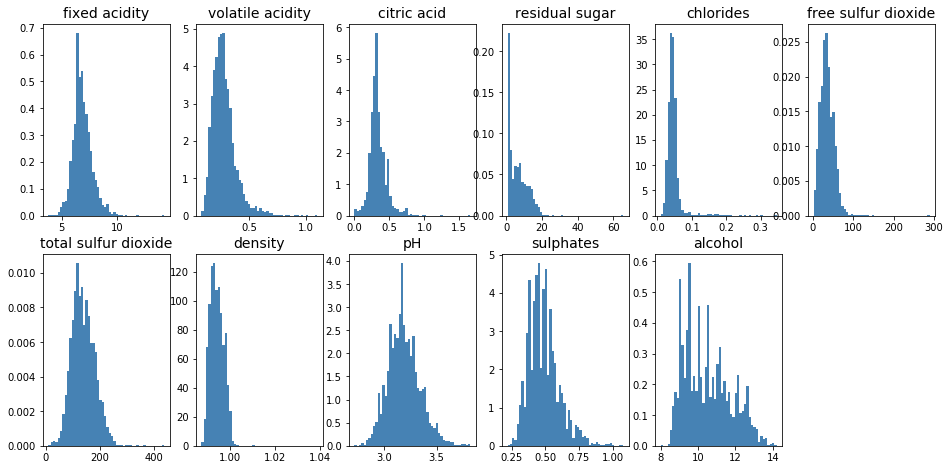

In [311]:
fig = plt.figure(figsize=(16,12))

for feature_i in range(x.shape[1]):
    x_axis = fig.add_subplot(3,6, (feature_i+1))
    h_axis = x_axis.hist(x[:, feature_i], bins=50, color="steelblue", density=True, edgecolor="none")
    x_axis.set_title(df.columns[feature_i], fontsize=14)
    

In [312]:
# labels noramlized
y_class = np.where(y<6,0,1)

In [313]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(x)
x_train_std = std_scale.transform(x)



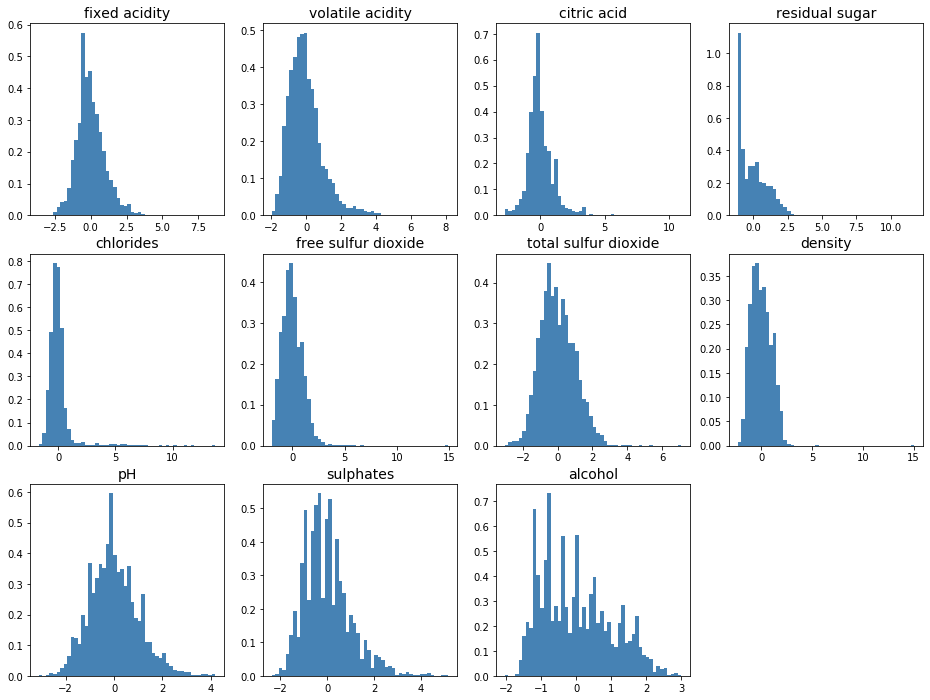

In [314]:
fig = plt.figure(figsize=(16, 12))

for feat_idx in range(x_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(x_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(df.columns[feat_idx], fontsize=14)


## Creating folds on train dataset

In [315]:



def split_n_folds(x_train_std, y_train, n_folds):
    # number of rows in dataset
    n = x_train_std.shape[0]
    normal_fold_size = n//n_folds
    last_fold_size = normal_fold_size + n - normal_fold_size*n_folds

    # first row
    # shape = (n_folds, 3) 
    # columns=  n , dt_test_part, dt_test_label
    cross_validation_data = np.array([[0,
                            x_train_std[:normal_fold_size,:],
                            y_train[:normal_fold_size]
                                             ]])
    #splitting up dataset into n_folds
    for i in range(1, n_folds): 
        if i < n_folds-1: # normal fold
            tmp = np.array([[i,
                            x_train_std[normal_fold_size*i:normal_fold_size*i+normal_fold_size,:],
                            y_train[normal_fold_size*i:normal_fold_size*i+normal_fold_size]
                                             ]])
        else: # last fold
            tmp = np.array([[i, x_train_std[-last_fold_size:, :], y_train[-last_fold_size:]]])
        
        cross_validation_data = np.concatenate((cross_validation_data, tmp))
    
    return cross_validation_data
        

    


In [316]:
data_set_in_folds = split_n_folds(x_train_std, y_class, n_folds)

In [317]:
print("normal fold size")
print(normal_fold_size)
print("last fold size")
print(last_fold_size)
print("------------------")
print("train x shape: ")
print(x_train_std.shape)
print("train y shape: ")
print(y_train.shape)
print("------------------")
print("fold n = 0")
print("train fold x shape: ")
print(cross_validation_data[0,1].shape)
print("train fold y shape: ")
print(cross_validation_data[0,2].shape)
print("------------------")
print("fold n = last fold")
print("train fold x shape: ")
print(cross_validation_data[-1,1].shape)
print("train fold y shape: ")
print(cross_validation_data[-1,2].shape)

normal fold size
685
last fold size
688
------------------
train x shape: 
(4898, 11)
train y shape: 
(785,)
------------------
fold n = 0
train fold x shape: 
(685, 11)
train fold y shape: 
(685,)
------------------
fold n = last fold
train fold x shape: 
(688, 11)
train fold y shape: 
(688,)


In [318]:
from sklearn import model_selection, neighbors, metrics
import pandas as pd

k_neighbor = 10

k_params = [3,5,7,9,11,13,15]

calculated_avg_error = []
df_result = pd.DataFrame({"k_neighbors": [], "n_fold": [], "accurency" : []}) 

for k_neighbor in k_params:
    for i in range(n_folds):
        x_train, x_test, y_train, y_test = model_selection.train_test_split(
                data_set_in_folds[i,1], data_set_in_folds[i, 2], test_size=0.2)

        knn = neighbors.KNeighborsClassifier(n_neighbors=k_neighbor)
        knn.fit(x_train, y_train)

        y_predict = knn.predict(x_test)
            
        # adding result to dataframe
        new_row = pd.DataFrame([[k_neighbor,i,metrics.accuracy_score(y_test, y_predict)]], columns=["k_neighbors","n_fold","accurency"])
        df_result = pd.concat([new_row, df_result])

    


    
    



# Model optimisation

In [319]:
result = df_result.groupby(['k_neighbors']).agg({"accurency": ["mean", "min", "max"]})
result

accurency                    
                 mean       min       max
k_neighbors                              
3.0          0.756299  0.724490  0.827411
5.0          0.774676  0.724490  0.817259
7.0          0.763498  0.698980  0.831633
9.0          0.762478  0.729592  0.811224
11.0         0.767554  0.729592  0.806122
13.0         0.759396  0.698980  0.841837
15.0         0.759360  0.683673  0.827411

In [320]:
# max value

result.where(result["accurency"]["mean"] == result.max(axis=0)["accurency"]["mean"]).dropna()


accurency                   
                 mean      min       max
k_neighbors                             
5.0          0.774676  0.72449  0.817259